In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from IPython.core.display import display, HTML

import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

base_path = "../" # Replace this with the path you want CROBAR putting files.
path.append(base_path+'3D_reconstruction_modules')
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions2 import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import bindown, estimate_aia_error, search_fido_response, bindown2
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission
sdo_data_dir = os.path.join(base_path,"data")
emtk_data_dir = '/home/jplowman/Research/Solar_Physics/EMToolKit/data/20100725'

plt.rcParams.update({'font.size': 18,'figure.figsize':[20,12],'image.origin':'lower'})

In [2]:
date='2010/07/25 00:16:30' # The date to use
datestr='20100725_001630' # A string describing the date for save file purposes
length_unit = u.cm

# Voxel size for CROBAR (0.42 Mm here)
dvox = np.array([(0.42*u.Mm).to(length_unit).value]*3)

# Voxel size for initial points:
flt_dvox = dvox*[1.0,1.0,10.0] # Initial point filtering voxel size
nloops_vol = 200 # Number of initial point randomly selected in the volume
nloops_flux = 5000 # Number of flux weighted initial points

# Value of force-free alpha to use for field line tracing:
alpha = 3.5/1.0e11 #*np.mean(1.0/(bounds0[1,0:2]-bounds0[0,0:2])**2)**0.5
#alpha = -8/1.0e11 #*np.mean(1.0/(bounds0[1,0:2]-bounds0[0,0:2])**2)**0.5
alphastr = str(round(alpha/1.0e-11,3))

psf_size_px = 0.7 # Default PSF size in pixels
#min_height = 1.0*dvox[2] # Loops must rise at least this high
#min_length = 8.0*np.mean(dvox) # Loops must be at least this long

min_height = 4.0*dvox[2] # Loops must rise at least this high
min_length = 20.0*np.mean(dvox) # Loops must be at least this long


# Start tracing this high above the solar surface:
ivp_z0 = 0.02*dvox[2]
ivp_xpo = 1.0
ivp_clip = 0.99

download = False # Download from VSO
newpoints = 0 # Generate new seed points
newtrace = 0 # Retrace field lines
newids = 0
newfwd = 0
newsoln = 1

save_path = os.path.join(base_path,'save')
plot_path = os.path.join(base_path,'plot','CROBAR3figs')

# Save footpoints to this file
footpoint_savefile = os.path.join(save_path,'footpoints_'+datestr+'.pickle')
# Save traced loops to this file:
loop_savefile = os.path.join(save_path,'loops_'+datestr+'_'+alphastr+'.pickle')
#id_savefile = os.path.join(save_path,'loopids_'+datestr+'_'+alphastr+'.pickle')
#id_savefile = os.path.join(save_path,'loopids_'+datestr+'_'+alphastr+'.pbz2')
id_savefile = os.path.join(save_path,'loopids_'+datestr+'_'+alphastr+'.pgz')

# X and y range of solar images to use for SDO/STEREO:
[x0, y0, xsz0, ysz0] = [-300, -650, 600, 400]
[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]
# X and Y ranges for STEREO A and B:
[xl_sta, xh_sta, yl_sta, yh_sta] = [-1200, -600, -650, -250]
[xl_stb, xh_stb, yl_stb, yh_stb] = [600, 1200, -650, -250]

# Voxels are padded inward from the crop range by this much:
vox_boundpad = np.array([[0.05,0.05,0.001],[-0.05,-0.05,-0.1]])
# Initial points are padded inward from the crop range by this much:
ivp_boundpad = np.array([[0.05,0.05,0.075],[-0.05,-0.05,-0.7]])

scaltemp1 = 1.2e6 # Temperature for estimating scale height of loop profile 1
scaltemp2 = 1.2e6 # Temperature for estimating scale height of loop profile 2
chan1_xpo = 2.0 # Assumed exponential power law index of the temperature response function
zmin0 = 2.63e8 # Minimum height

scaltemp1str = str(scaltemp1/1.0e4)[0:3]
scaltemp2str = str(scaltemp2/1.0e4)[0:3]
chan1_xpostr = str(chan1_xpo*100)[0:3]

fwdmat_savefile = os.path.join(save_path,'fwdmat_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastr+'.pgz')
soln_savefile = os.path.join(save_path,'soln_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastr+'.pgz') 

print(footpoint_savefile,loop_savefile,fwdmat_savefile,soln_savefile)

../save/footpoints_20100725_001630.pickle ../save/loops_20100725_001630_3.5.pickle ../save/fwdmat_20100725_001630_120_120_200_3.5.pgz ../save/soln_20100725_001630_120_120_200_3.5.pgz


In [3]:
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = nloops_vol+nloops_flux
flux_factor = dvox[0]*dvox[1]
gfac = 1.0/2.2
length_unit = u.cm

# Massaging the x and y ranges:
cropr_stereoa = [xl_sta,xh_sta,yl_sta,yh_sta]*u.arcsec
cropr_stereob = [xl_stb,xh_stb,yl_stb,yh_stb]*u.arcsec
cropr = [x0-xsz0*(vox_boundpad[0,0]/(1-vox_boundpad[0,0])),x0+xsz0/(1+vox_boundpad[1,0]),
        y0-ysz0*(vox_boundpad[0,1]/(1-vox_boundpad[0,1])),y0+ysz0/(1+vox_boundpad[1,1])]*u.arcsec
cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*u.arcsec

In [4]:
if(download):
    # Download fresh from the VSO:
    time_range = TimeRange(TimeRange(date,-1800*u.s).start,TimeRange(date,1800*u.s).end)
    qry_stereo = Fido.search(a.Time(time_range),a.Instrument('SECCHI'),a.Wavelength(284*u.angstrom))
    sta_hits = search_fido_response(qry_stereo,'STEREO_A')[0]
    stereoadat_path = Fido.fetch(qry_stereo[sta_hits[0],sta_hits[1]],path=sdo_data_dir)
    print(stereoadat_path)

    stb_hits = search_fido_response(qry_stereo,'STEREO_B')[0]
    stereobdat_path = Fido.fetch(qry_stereo[stb_hits[0],stb_hits[1]],path=sdo_data_dir)
    print(stereobdat_path)

    time_range = TimeRange(TimeRange(date,-6*u.s).start,TimeRange(date,6*u.s).end)
    qry_aia335 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(335*u.angstrom))
    aia335dat_path = Fido.fetch(qry_aia335[0][0],path=sdo_data_dir)
    print(aia335dat_path)

    time_range = TimeRange(TimeRange(date,-6*u.s).start,TimeRange(date,6*u.s).end)
    qry_aia171 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(171*u.angstrom))
    aia171dat_path = Fido.fetch(qry_aia171[0][0],path=sdo_data_dir)

    time_range = TimeRange(TimeRange(date,-1200*u.s).start,TimeRange(date,1200*u.s).end)
    qry_mdi = Fido.search(a.Time(time_range),a.Instrument('MDI'),vso.attrs.Physobs('LOS_magnetic_field'))
    magnetogram_path = Fido.fetch(qry_mdi[0][0],path=sdo_data_dir)
else:
    # These filenames may be need to be updated if its redownloaded or other data is used:
    stereoadat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eua.fts')
    stereobdat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eub.fts')
    aia335dat_path = os.path.join(emtk_data_dir,'aia_lev1_335a_2010_07_25t00_16_39_63z_image_lev1.fits')
    aia284dat_path = os.path.join(emtk_data_dir,'aia_lev1_synth284a_2010_07_25t00_16_39_63z_image_lev1.fits')
    aia_pwr2dat_path = os.path.join(emtk_data_dir,'pwrlaw2_synthdata_aia_072510.fits')
    aia171dat_path = os.path.join(sdo_data_dir,'aia.lev1.171A_2010-07-25T00 16 00.34Z.image_lev1.fits')
    magnetogram_path = os.path.join(sdo_data_dir,'mdi.fd_M_96m_lev182.2010.07.25_00:00:00_TAI.data.fits')

In [5]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)#.rotate(order=3)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

aia335map = Map(aia335dat_path)
blc=SkyCoord(cropr[0],cropr[2],frame=aia335map.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=aia335map.coordinate_frame)
aia335map = aia335map.submap(blc,top_right=trc)

aia_pwr2map = Map(aia_pwr2dat_path)
blc=SkyCoord(cropr[0],cropr[2],frame=aia_pwr2map.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=aia_pwr2map.coordinate_frame)
aia_pwr2map = aia_pwr2map.submap(blc,top_right=trc)

aia284map = Map(aia284dat_path)
blc=SkyCoord(cropr[0],cropr[2],frame=aia284map.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=aia284map.coordinate_frame)
aia284map = aia284map.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

rsun_cm = magnetogram.center.rsun.to(length_unit).value

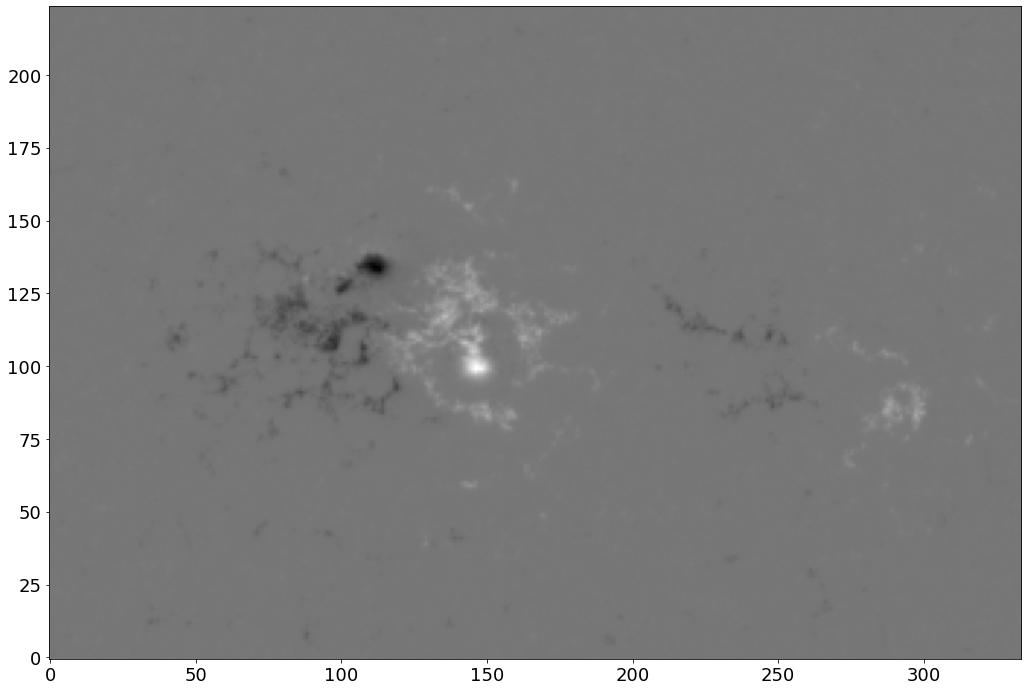

In [6]:
plt.imshow(np.fliplr(magnetogram.data),cmap=plt.get_cmap('gray'))

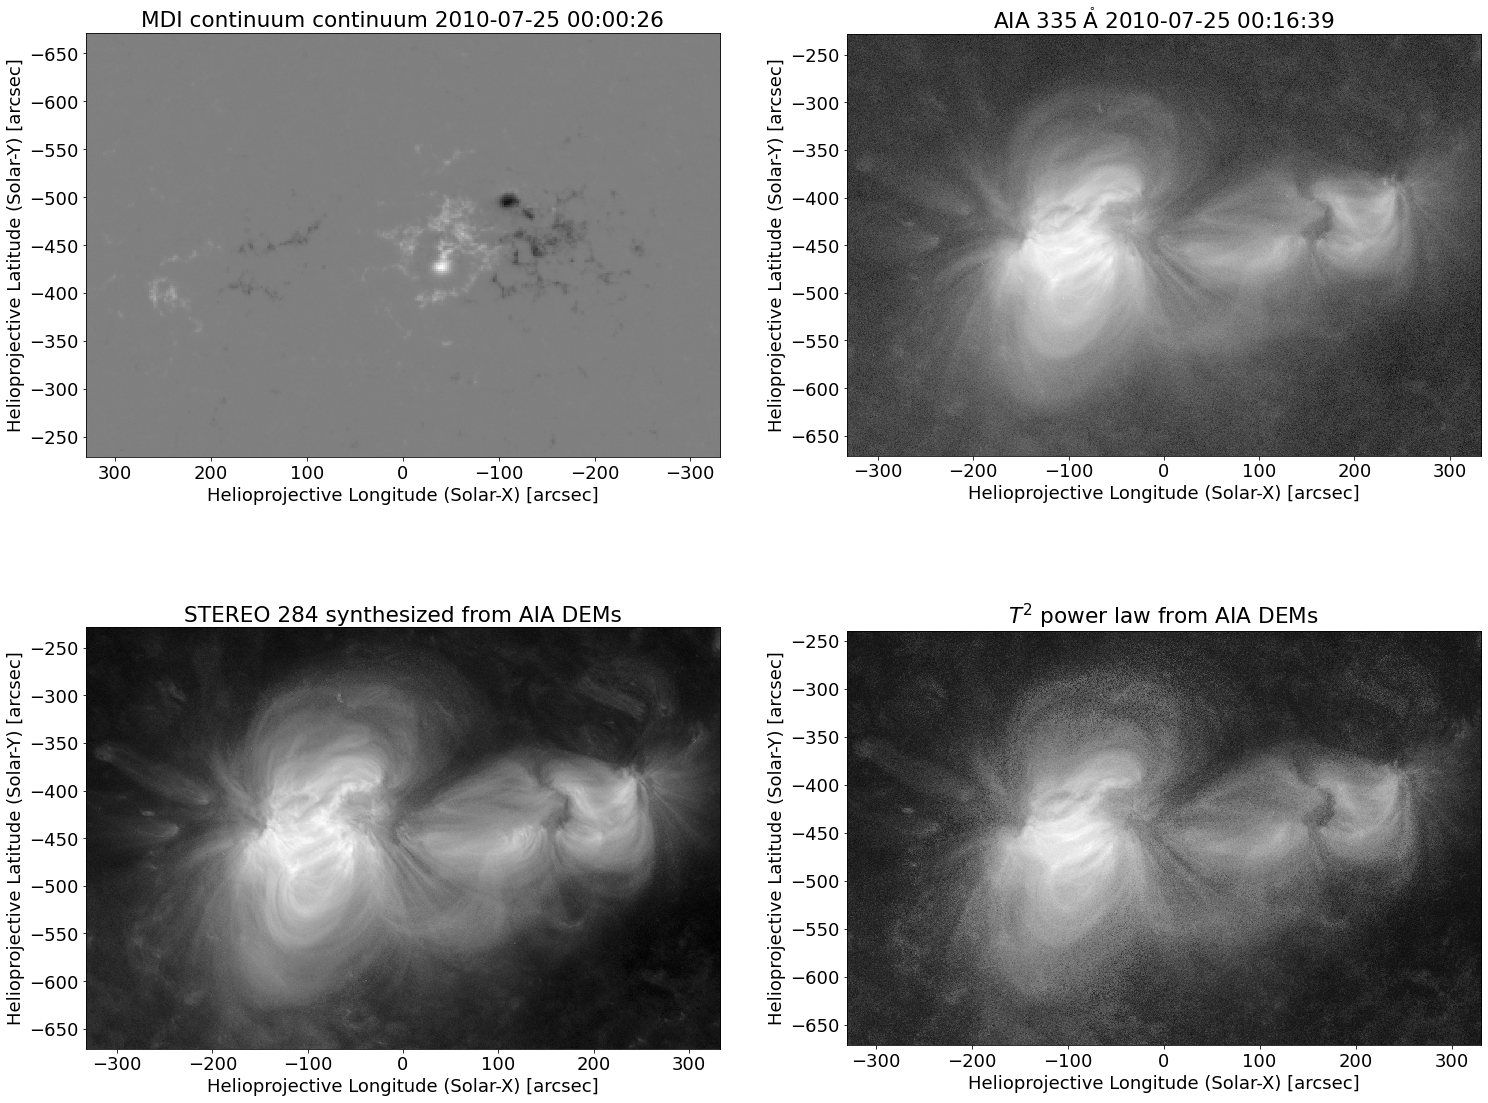

In [7]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=[25,20])

magnetogram.plot(axes=axes[0,0])

aia335map.plot(cmap=plt.get_cmap('gray'),axes=axes[0,1])

aia284map.plot(cmap=plt.get_cmap('gray'),axes=axes[1,0])
axes[1,0].set(title='STEREO 284 synthesized from AIA DEMs')

aia_pwr2map.plot(cmap=plt.get_cmap('gray'),axes=axes[1,1])
axes[1,1].set(title=r'$T^2$ power law from AIA DEMs')

plt.savefig(os.path.join(plot_path,'hmi_aia_quadplot'+'.pdf'),bbox_inches='tight')

In [8]:
# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + 0.625*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm

# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,dvox,offsets=[0.5,0.5,0.0],pad=vox_boundpad)
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,flt_dvox,offsets=[0.5,0.5,0.0])

In [9]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2, but largely not needed with the MDI 
# magnetogram used in this example):
mag_trace = copy.deepcopy(mag) # bindown2(mag[:,:,0],2)/4
mag_coords_trace = copy.deepcopy(mag_coords) # np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [10]:
footpoint_path = footpoint_savefile
if(newpoints):
    ivp_bounds = tracer_bounds+ivp_boundpad*(tracer_bounds[1]-tracer_bounds[0])
    volume_initial_points = volume_seed_points(nloops_vol, ivp_bounds)
    #fluxw_initial_points = fluxweighted_seed_points2(nloops_flux, mag, mag_coords, ivp_bounds, z0=ivp_z0, xpo=ivp_xpo, clip=ivp_clip)
    fluxw_initial_points = hilbert_seed_points(nloops_flux, mag, mag_coords, ivp_z0, rsun=rsun_cm)
    initialpoint_dict = {'xydomain':[x0,y0,xsz0,ysz0], 'vox_boundpad':vox_boundpad, 'ivp_boundpad':ivp_boundpad, 
                         'dvox':dvox, 'min_height':min_height, 'min_length':min_length, 'magnetogram_path':magnetogram_path, 
                         'date':date, 'datestr':datestr, 'magnetogram':magnetogram, 'mag':mag, 'mag_coords':mag_coords,
                         'ivp_bounds':ivp_bounds, 'ivp_z0':ivp_z0, 'ivp_xpo':ivp_xpo, 'ivp_clip':ivp_clip, 'cropr':cropr,
                         'cropr0':cropr0, 'vox_grid':vox_grid, 'volume_initial_points':volume_initial_points, 
                         'fluxw_initial_points':fluxw_initial_points, 'flt_grid':flt_grid, 'tracer_bounds':tracer_bounds}

    filehandler = open(footpoint_path,"wb")
    pickle.dump(initialpoint_dict,filehandler)
    filehandler.close()
if(not(newpoints)):
    file = open(footpoint_path,'rb')
    initialpoint_dict = pickle.load(file)
    file.close()
    fluxw_initial_points = initialpoint_dict['fluxw_initial_points']
    volume_initial_points = initialpoint_dict['volume_initial_points']
    ivp_bounds = initialpoint_dict['ivp_bounds']
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [11]:
# Plot the initial points over the magnetogram:
fluxw_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in fluxw_initial_points]
volume_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in volume_initial_points]

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 224.0)

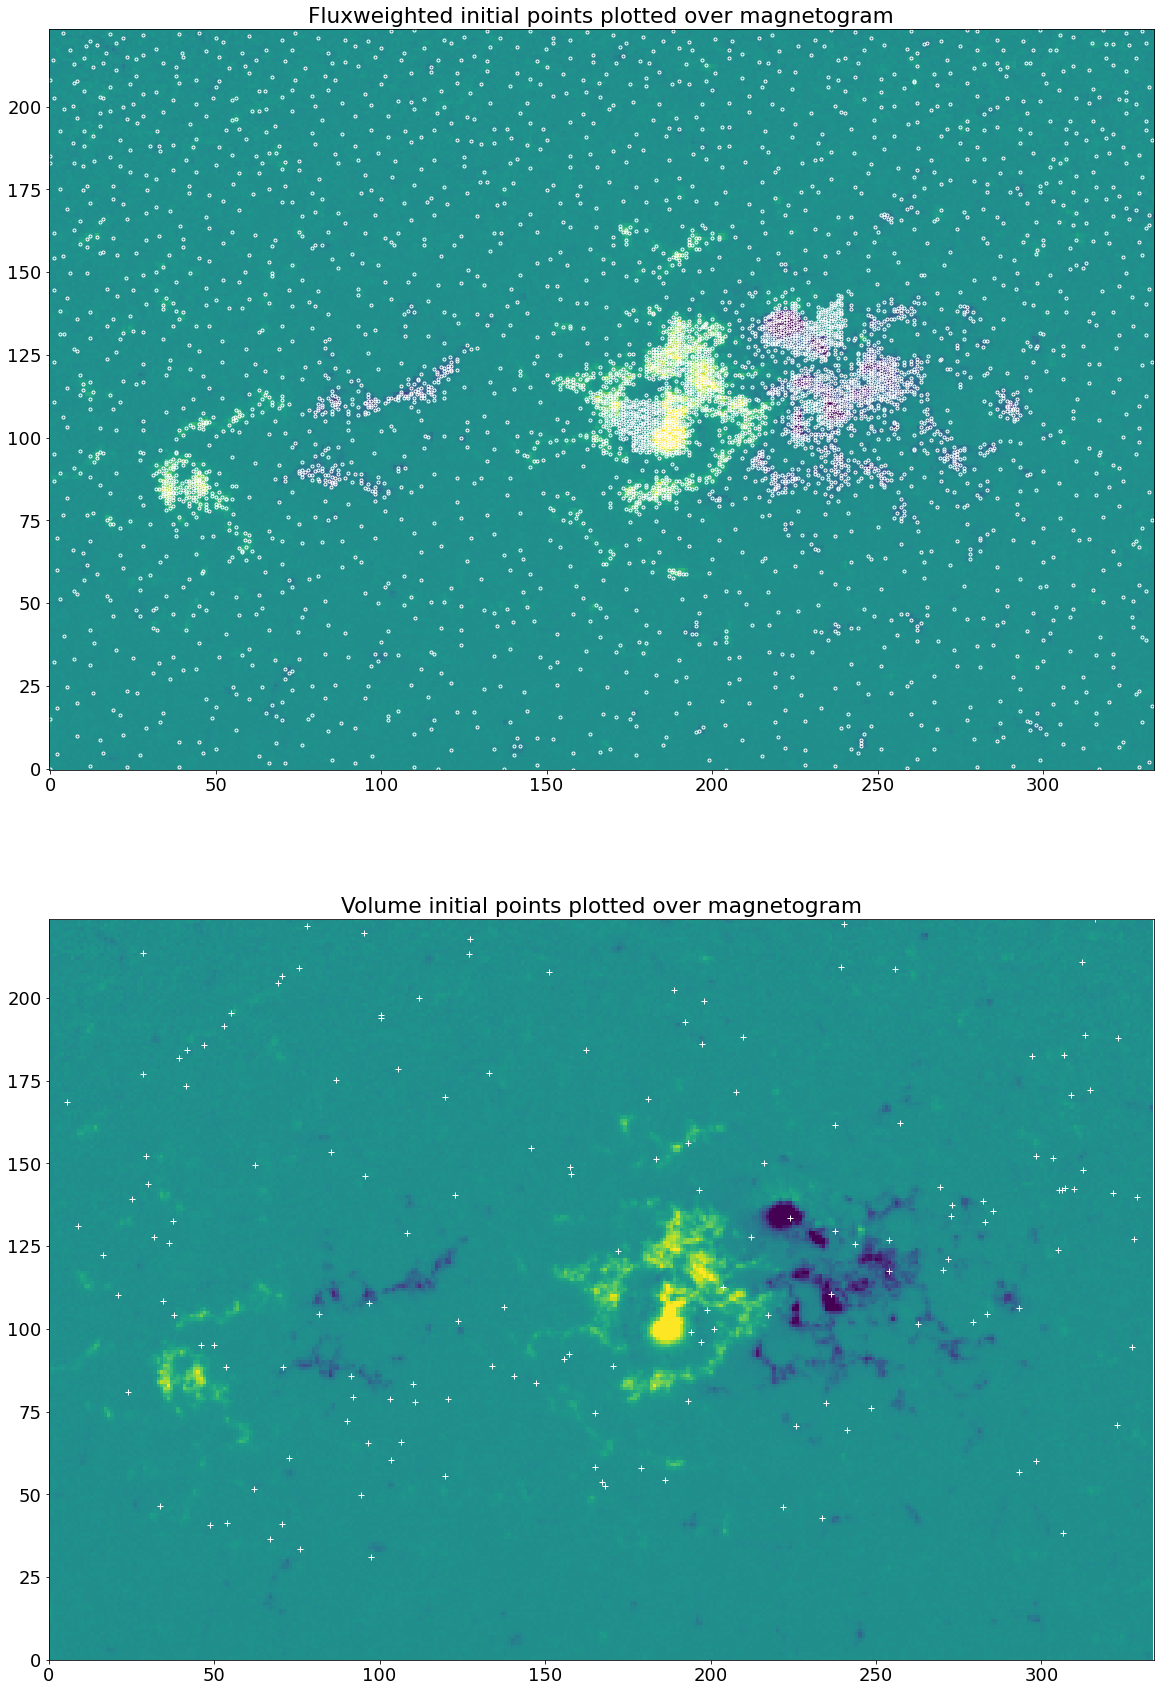

In [12]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(2,1,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [13]:
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [14]:
print(alphastr,loop_savefile)
# Trace field lines if newtrace is true:
if(newtrace or os.path.exists(loop_savefile)==False):
    fieldlines = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=magnetogram.center.rsun.to(u.cm).value)
    filehandler = open(loop_savefile,"wb")
    pickle.dump(fieldlines,filehandler)
    filehandler.close()
# Otherwise reload from the previously specified file:
else:
    file = open(loop_savefile,'rb')
    fieldlines = pickle.load(file)
    file.close()

3.5 ../save/loops_20100725_001630_3.5.pickle


In [15]:
import loop_processing
importlib.reload(loop_processing)
from loop_processing import resample_loops, filter_loops

In [16]:
# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
[fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm,bvecs=fieldlines[1])
# Filter out loops whose footpoints fall too close together:
[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)
nloops = len(fieldlines_filter)
print(nloops0,nloops)

5200 2230


In [19]:
print(len(lengths),len(lengths_filter),nloops)

5200 2230 2230


In [26]:
fieldlines_filter[0][0,0:3]

array([-2.6669757e+09, -1.3288972e+09, -6.3173440e+07], dtype=float32)

In [17]:
#alphas = np.array([-10,-8,-6,-4,-2,0,2,3,3.5,4,5,6,8,10])*1.0e-11
alphas = np.array([-10,-8,-6,-4,-2,0,2,3,3.5,4,5,6,8,10])*1.0e-11
nalphas = len(alphas)
[loop_savefiles,id_savefiles,fwdmat_savefiles,soln_savefiles] = [[],[],[],[]]
alphastrs = [str(round(alphai/1.0e-11,3)) for alphai in alphas]
for i in range(0,len(alphas)):
    loop_savefiles.append(os.path.join(save_path,'loops_'+datestr+'_'+alphastrs[i]+'.pickle'))
    fwdmat_savefiles.append(os.path.join(save_path,'fwdmat_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastrs[i]+'.pgz'))
    soln_savefiles.append(os.path.join(save_path,'soln_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastrs[i]+'.pgz'))
    id_savefiles.append(os.path.join(save_path,'loopids_'+datestr+'_'+alphastrs[i]+'.pgz'))


In [18]:
import loop_processing
importlib.reload(loop_processing)
from loop_processing import resample_loops
from forcefree_field import compute_lff_field

field_strengths = []
field_strength_lengths = []
potential_field_strengths = []
potential_field_strength_lengths = []
tstart=time.time()
for i in range(0,nalphas):
    file = open(loop_savefiles[i],'rb')
    fieldlines = pickle.load(file)
    file.close()
    # Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
    [fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm,bvecs=fieldlines[1])
    # Filter out loops whose footpoints fall too close together:
    [fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)

    #alphastr = str(round(alphas[i]/1.0e-12))
    #savefile = 'reconstruct_'+datestr+'_alpha'+alphastr+'.pickle'
    #file = open(base_path+savefile,'rb')
    #savedict = pickle.load(file)
    #file.close()

    #[fieldlines_resamp2,lengths2] = resample_loops(savedict['fieldlines_filter'],bounds0,0.5*np.mean(dvox),lfrac=0.05,zfrac=0.2, z0 = bounds0[0,2]+0.125*dvox[2])
    #[fieldlines_resamp2,lengths2] = resample_loops(savedict['fieldlines_filter'],bounds0,0.5*np.mean(dvox),lfrac=0.05,zfrac=0.2)
    current_field_strengths = []
    current_potential_field_strengths = []
    for line in fieldlines_filter:
        npt = len(line)
        field_strength = np.zeros(npt)
        potential_field_strength = np.zeros(npt)
        # Need to evaluate potential field strengths at exactly the same place as the regular field strengths in order to get free energies
        for j in range(0,npt): potential_field_strength[j] = np.sum(np.array(compute_lff_field(None,line[j,0:3],mag_coords_trace,mag,0.0))**2)**0.5
        current_potential_field_strengths.append(potential_field_strength)
        for j in range(0,npt): field_strength[j] = np.sum(np.array(compute_lff_field(None,line[j,0:3],mag_coords_trace,mag,alphas[i]))**2)**0.5
        current_field_strengths.append(field_strength)
#savedict=0
    field_strengths.append(current_field_strengths)
    field_strength_lengths.append(lengths_filter)
    potential_field_strengths.append(current_potential_field_strengths)
    potential_field_strength_lengths.append(lengths_filter)
    print(i)


0
1
2


KeyboardInterrupt: 

In [ ]:
file = open(os.path.join(save_path,'fieldstrengths_'+datestr+'.pickle'),'wb')
pickle.dump([field_strengths,field_strength_lengths],file)
file.close()
print('fieldstrengths_'+datestr+'.pickle')

file = open(os.path.join(save_path,'potential_fieldstrengths_'+datestr+'.pickle'),'wb')
pickle.dump([potential_field_strengths,potential_field_strength_lengths,alphas],file)
file.close()
print('fieldstrengths_'+datestr+'.pickle')

In [73]:
nls = np.zeros(len(field_strengths[0]))
for i in range(0,len(nls)): nls[i] = len(field_strengths[0][i])
print(np.min(nls),np.max(nls))

30.0 254.0


In [16]:
# Create core voxel cube identifying every voxel with a loop:
if(newids or newtrace or os.path.exists(id_savefile)==False):
    [loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)

In [52]:
print(len(fieldlines_filter))

2217


In [17]:
#id_savefile = os.path.join(save_path,'loopids_'+datestr+'_'+alphastr+'.pbz2')
#id_savefile = os.path.join(save_path,'loopids_'+datestr+'_'+alphastr+'.pgz')

print(id_savefile)

../save/loopids_20100725_001630_10.0.pgz


In [18]:
import bz2
import gzip
from zipfile import ZipFile

In [19]:
tstart=time.time()
# Trace field lines if newtrace is true:
if(newids or newtrace or os.path.exists(id_savefile)==False):
    #filehandler = bz2.BZ2File(id_savefile, 'w',compresslevel=1)
    filehandler = gzip.GzipFile(id_savefile, 'wb')
    #filehandler = open(id_savefile,"wb")
    pickle.dump([loopids, loopid_info, voxel_loop_lengths],filehandler)
    filehandler.close()
    print(time.time()-tstart)
else:
    filehandler = gzip.GzipFile(id_savefile, 'rb')
    #filehandler = ZipFile(id_savefile, 'rb')
    #file = open(id_savefile,'rb')
    [loopids, loopid_info, voxel_loop_lengths] = pickle.load(filehandler)
    filehandler.close()

In [20]:
#newfwd = 0
#newsoln = 0

#fwdmat_savefile = os.path.join(save_path,'fwdmat_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastr+'.pickle')
#soln_savefile = os.path.join(save_path,'soln_'+datestr+'_'+scaltemp1str+'_'+scaltemp2str+'_'+chan1_xpostr+'_'+alphastr+'.pickle') 

In [21]:
def get_limb(vox_grid,rsun_cm):
    coorda = np.zeros([vox_grid.dims[0],vox_grid.dims[1],1,3],dtype=np.float32)
    for i in range(0,vox_grid.dims[0]): coorda[i,:,:,0] = i
    for i in range(0,vox_grid.dims[1]): coorda[:,i,:,1] = i

    limb = np.zeros([vox_grid.dims[0],vox_grid.dims[1],vox_grid.dims[2]],dtype=np.bool)
    for i in range(0,vox_grid.dims[2]):
        coorda[:,:,0,2] = i
        coords = vox_grid.coords(coorda)
        rads = np.sqrt(np.sum(coords[:,:,:,0:2]**2,axis=3)+(coords[:,:,:,2]+rsun_cm)**2)
        limb[:,:,i] = (rads > rsun_cm)[:,:,0]
    return limb

limb_mask = get_limb(vox_grid,rsun_cm)

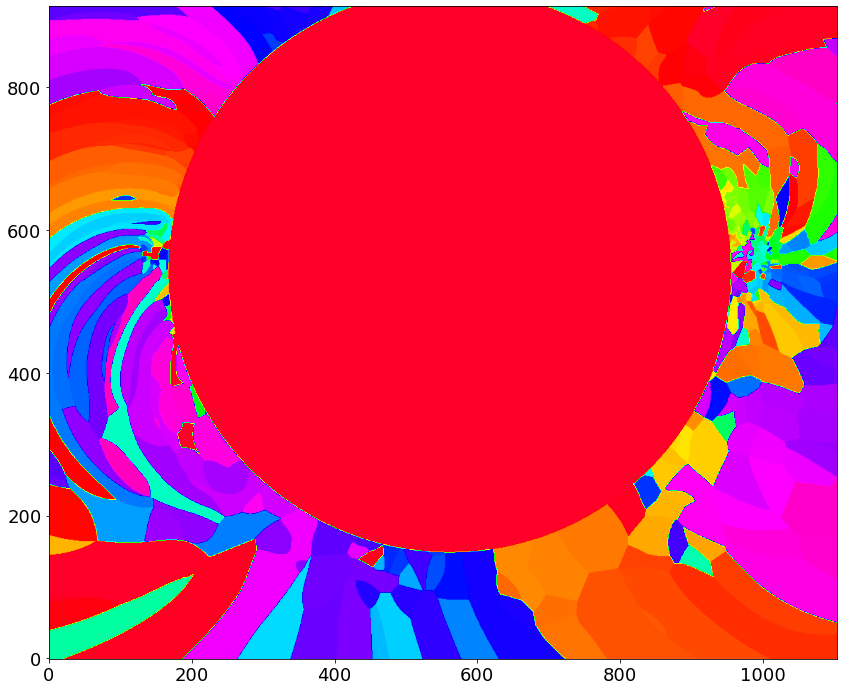

In [22]:
# This is a slice of the voxel label cube at a particular height with the limb mask applied,
# showing each loop as a different color
plt.imshow((limb_mask[:,:,150]*loopids[:,:,150] % 200).T, origin='lower',cmap=plt.get_cmap('gist_rainbow'))

In [23]:
print(np.mean(aia_pwr2map.data),np.mean(aia335map.data))

31.405595141924167 29.518527063649014


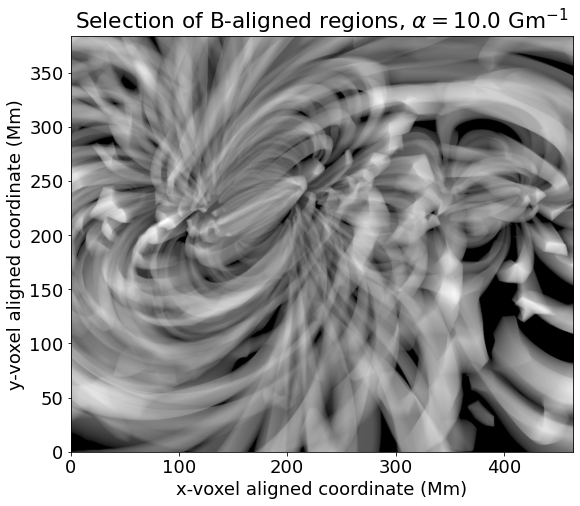

In [24]:
# This is a sum through the cube with every 5th loop illuminated:
fig=plt.figure(figsize=[9,9])
plt.imshow(np.sum(limb_mask*(loopids % 5 == 0),axis=2).T**gfac,extent=[0,vox_grid.dims[0]*dvox[0]/1.0e8,0,vox_grid.dims[1]*dvox[1]/1.0e8], cmap=plt.get_cmap('gray'))
plt.title(r'Selection of B-aligned regions, $\alpha=$'+alphastr +r' Gm$^{-1}$')
plt.xlabel('x-voxel aligned coordinate (Mm)')
plt.ylabel('y-voxel aligned coordinate (Mm)')
plt.savefig(os.path.join(plot_path,'bars_alpha'+alphastr+'.pdf'),bbox_inches='tight')

In [25]:
# Crop the data for the reconstruction in a bit compared to the cube. This improves the ability of the 
# reconstruction to fit the data, although it does also mean that the edges of the reconstruction are 
# underconstrained. 
cropr = cropr0+np.array([10,-10,10,-10])*u.arcsec
if(newids or newtrace or newfwd or os.path.exists(fwdmat_savefile)==False):
    # Compute the forward matrix from the field-aligned regions to the data:
    [amat,modelinputs] = compute_fwdmat(aia_pwr2dat_path, None, loopids, loopid_info,
                                        vox_grid, cropr, magnetogram, voxel_loop_lengths, curvature=False, 
                                        vox_mask=limb_mask, xpo1 = chan1_xpo, xpo2 = chan1_xpo, temp1=scaltemp1, 
                                        psf_size_px=0.4, zmin=np.min(mag_coords[2]), temp2=scaltemp2, asym=True)
    filehandler = gzip.GzipFile(fwdmat_savefile, 'wb')
    pickle.dump([amat,modelinputs],filehandler)
    filehandler.close()
else:
    filehandler = gzip.GzipFile(fwdmat_savefile, 'rb')
    [amat,modelinputs] = pickle.load(filehandler)
    filehandler.close()

In [26]:
# Error estimates for the reconstruction:
#errmap = copy.deepcopy(modelinputs['map']) # For Synthetic 284
#errmap.data[::] /= 10
#chan1_err = 10*estimate_aia_error(errmap)

errmap = copy.deepcopy(modelinputs['map'])
chan1_err = estimate_aia_error(errmap)
# Reconstruct using the forward matrix:
if(newids or newtrace or newfwd or newsoln or os.path.exists(soln_savefile)==False):
    solution = reconstruct(amat, modelinputs, reg_fac=0.1, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5)
    filehandler = gzip.GzipFile(soln_savefile, 'wb')
    pickle.dump(solution,filehandler)
    filehandler.close()
else:
    filehandler = gzip.GzipFile(soln_savefile, 'rb')
    solution = pickle.load(filehandler)
    filehandler.close()


1.4114191335107142 20.52842836688155 704.7382
Overall regularization factor: 7.626885631153724e-05
5565.689869533938 5565.689869533938 8.624376221800816 8.624376221800816
25.58 s i = 0 chi2 = 63.2 step size = 0.3 reg. param. = 1.28 chi2 change = 54.37903 reg. change = -0.79155
0 8.600229549520693 0.47643015784279585 7.6645946118945085 12.650500084368609
5565.689869533938 5565.689869533938 7.6645946118945085 12.650500084368609
47.56 s i = 1 chi2 = 14.99 step size = 0.85 reg. param. = 1.11 chi2 change = 48.20798 reg. change = 0.17269
1 8.188843872308494 1.004403026648226 3.330565599651239 12.015880033369063
5565.689869533938 5565.689869533938 3.330565599651239 12.015880033369063
76.98 s i = 2 chi2 = 4.92 step size = 0.85 reg. param. = 0.97 chi2 change = 10.07533 reg. change = 0.1416
2 7.580626104870558 1.8352440087821054 -6.53910153869252 11.573595607171063
5565.689869533938 5565.689869533938 -6.53910153869252 11.573595607171063
98.54 s i = 3 chi2 = 2.74 step size = 0.85 reg. param. = 0.

In [27]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/modelinputs['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(modelinputs['loop_weights']*soln)).reshape(modelinputs['map'].data.shape)

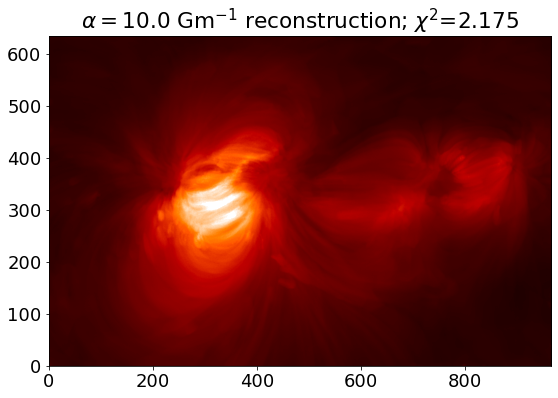

In [28]:
pltmax = 500
fig=plt.figure(figsize=[9,9])
plt.imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
plt.title(r'$\alpha=$'+alphastr+' Gm$^{-1}$ reconstruction; $\chi^2$='+str(solution[1])[0:5])
plt.savefig(os.path.join(plot_path,'reconstruct_alpha'+alphastr+'.pdf'),bbox_inches='tight')

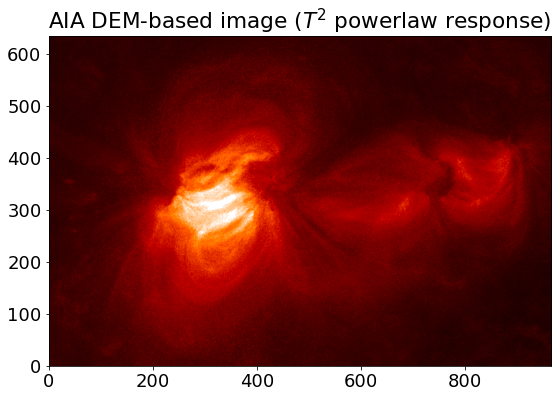

In [30]:
pltmax = 500
fig=plt.figure(figsize=[9,9])
plt.imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
plt.title(r'AIA DEM-based image ($T^2$ powerlaw response)')
plt.savefig(os.path.join(plot_path,'original_aia_t2pwrlaw.pdf'),bbox_inches='tight')

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

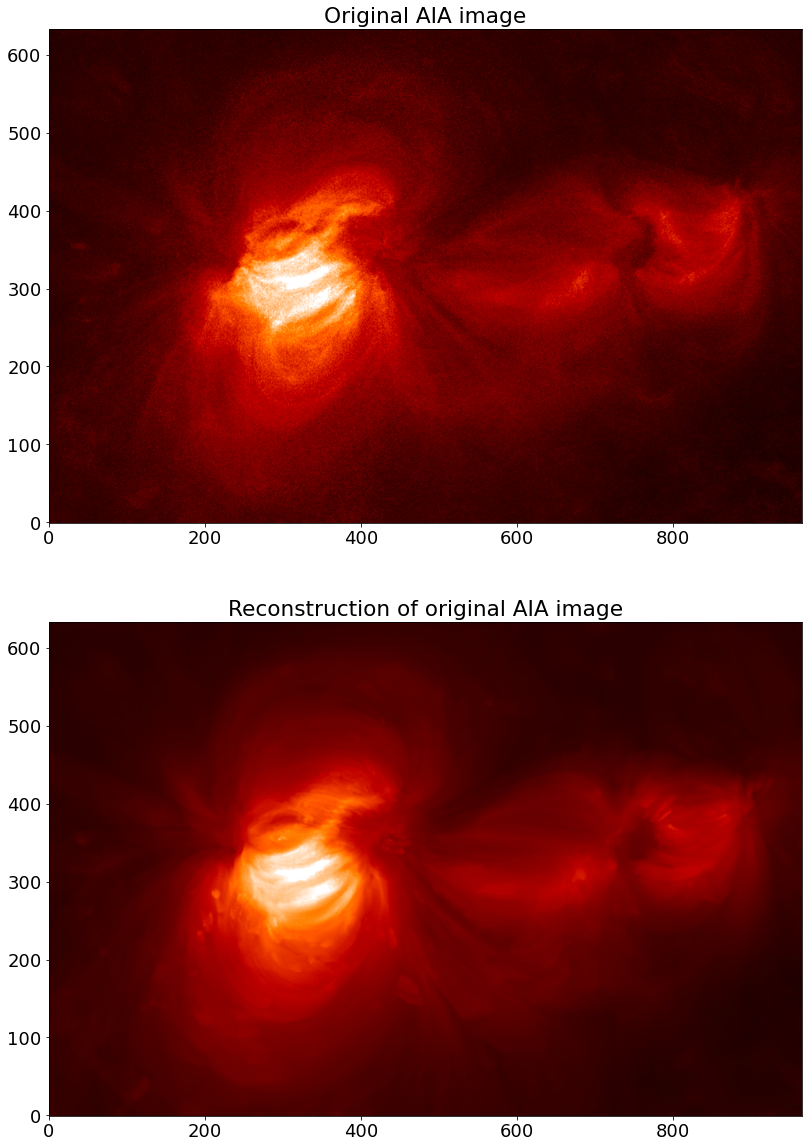

In [29]:
pltmax = 500

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=[20,20])
axes[0].imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [47]:
# Expand the solution into a 3D emission cube: 
em3d = get_3d_emission(solution[0], modelinputs, vox_grid, loopids, voxel_loop_lengths, loopid_info, zmin=np.min(mag_coords[2]))

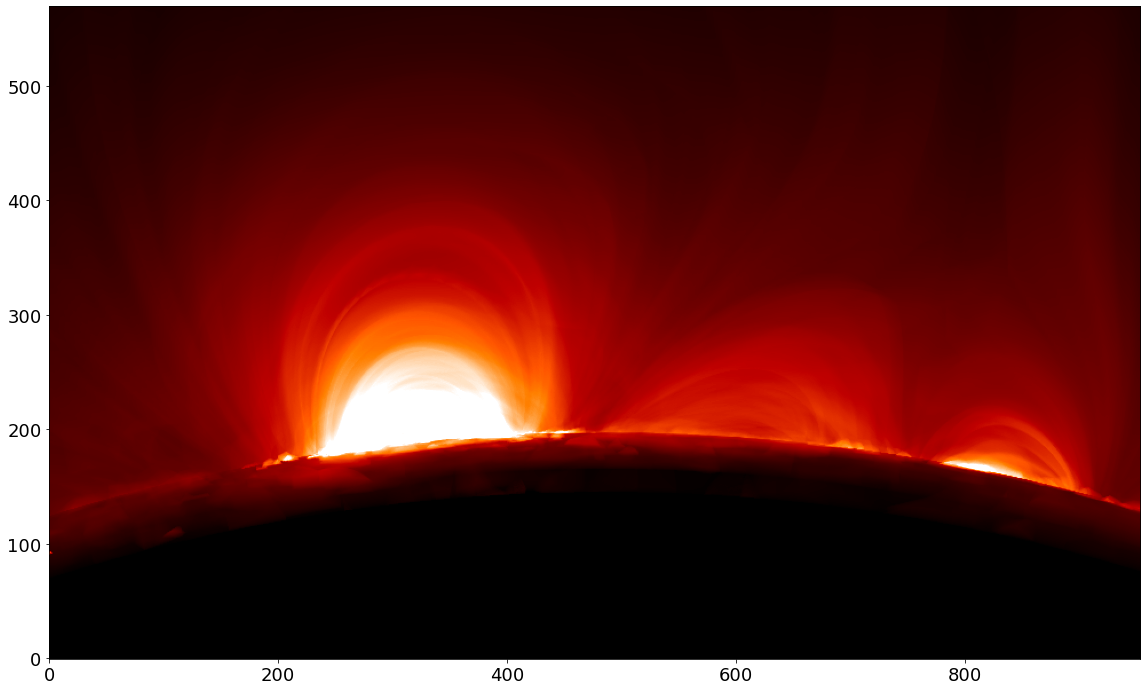

In [49]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from the pole):
plt.imshow(np.sum(limb_mask[75:-75,130:870,:]*em3d[75:-75,130:870,:],axis=1).T**gfac,vmin=0,vmax=1.0e-4**gfac,cmap=plt.get_cmap('gist_heat'))

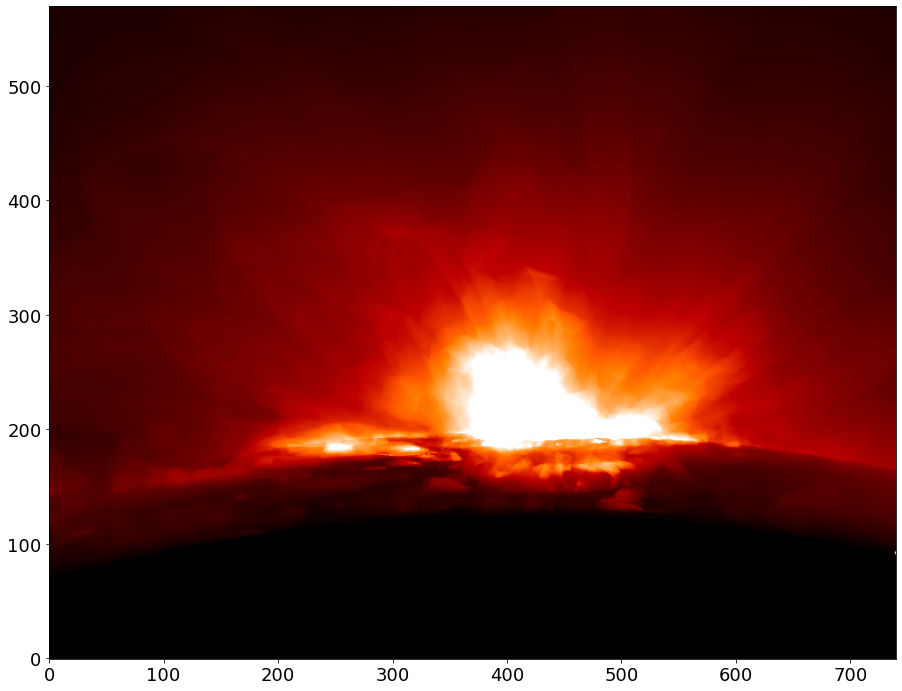

In [55]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from ecliptic latitude):
plt.imshow(np.sum(limb_mask[75:-75,130:870,:]*em3d[75:-75,130:870,:],axis=0).T**gfac,vmin=0,vmax=1.0e-4**gfac,cmap=plt.get_cmap('gist_heat'))

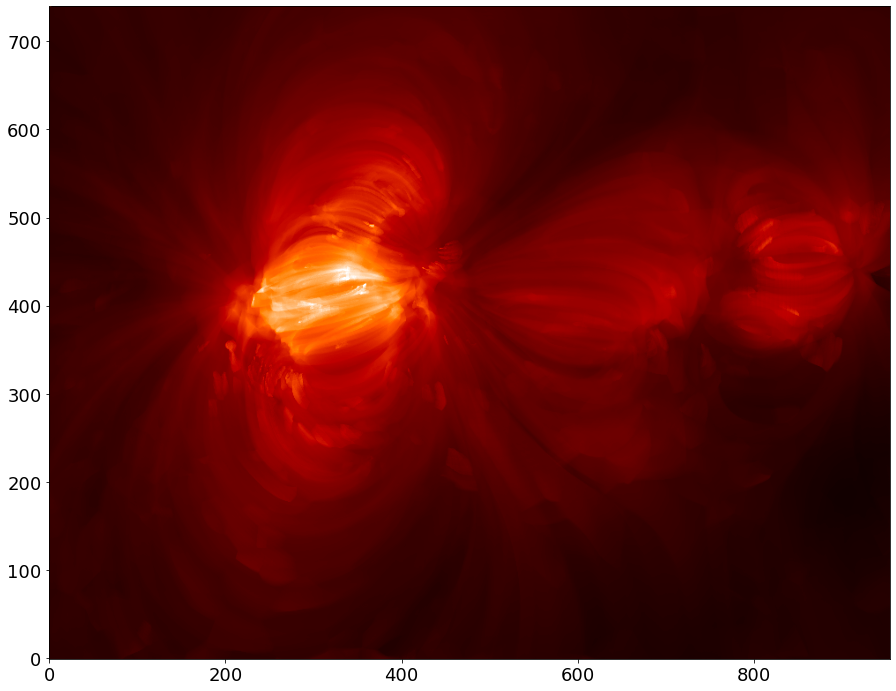

In [56]:
# Plot the x-y projection through the cube (e.g., as viewed from directly overhead):
plt.imshow(np.sum(limb_mask[75:-75,130:870,:]*em3d[75:-75,130:870,:],axis=2).T**gfac,vmin=0,vmax=1.0e-4**gfac,cmap=plt.get_cmap('gist_heat'))